In [49]:
from tests.helpers import random_orientation, random_position
from imusim.maths.quaternions import QuaternionArray, Quaternion
from imusim.testing.random_data import RandomTrajectory
from imusim.trajectories.sampled import SampledTrajectory
from imusim.trajectories.splined import SplinedTrajectory
from imusim.utilities.time_series import TimeSeries
import functools
import time
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.optimize
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib.gridspec import GridSpec
from crisp.camera import AtanCameraModel
from rsimusim.camera import PinholeModel
from rsimusim.misc import CalibratedGyroStream
from rsimusim.dataset import Dataset
%matplotlib inline

In [73]:
def project_at_time(t, landmark, trajectory, camera_model):
    R = np.array(trajectory.rotation(t).toMatrix())
    p = trajectory.position(t)
    T = np.hstack((R.T, np.dot(R.T, -p)))
    Xh = np.ones((4,1))
    Xh[:3] = landmark
    landmark_camera = np.dot(T, Xh)
    return camera_model.project(landmark_camera)

def cost_function_base(t0, landmark, trajectory, camera_model, row, method='abs'):
    row_delta = camera_model.readout / float(camera_model.rows)
    t = t0 + row * row_delta
    x, y = project_at_time(t, landmark, trajectory, camera_model).ravel()
    residual = row - y
    if method == 'abs':
        return np.abs(residual)
    elif method == 'linear':
        return residual
    else:
        raise ValueError('No such method {}'.format(method))

In [3]:
focal = 550.
image_size = (1920, 1080)
K = np.array([[focal, 0, image_size[0]/2.],
             [0, focal, image_size[1]/2.],
             [0, 0, 1]])
fps = 30.
readout = 0.95 / fps
pinhole_camera = PinholeModel(K, image_size, readout, fps)

In [4]:
atan_camera = AtanCameraModel.from_hdf('/home/hannes/Code/crisp/hero3_atan.hdf')

## Load dataset from file
Contains trajectory and landmarks

In [5]:
ds = Dataset.from_file('rccar_openmvg.h5')

## Find misbehaving cases
Try to project using the linear model.
Filter out any point that do not agree with truth up to a threshold (less than a row).
Points that do not have a minimum absolute cost close to 0 are not visible *using the current camera model*.

In [56]:
duration = ds.trajectory.endTime - ds.trajectory.startTime
num_frames = int(pinhole_camera.frame_rate * duration)
rows = np.arange(pinhole_camera.rows)
frame_times = ds.trajectory.startTime + np.arange(num_frames) / pinhole_camera.frame_rate
a = int(0.2 * pinhole_camera.rows)
b = int(0.8 * pinhole_camera.rows)
max_lm_for_frame = 3

pbar = IntProgress(min=0, max=len(frame_times)-1)
display(pbar)
problematic = []
for t0 in frame_times:
    lm_for_frame = 0
    landmarks = ds.visible_landmarks(t0 + 0.5*pinhole_camera.readout)
    random.shuffle(landmarks)
    for lm in landmarks:
        X = lm.position.reshape(3,1)
        cost_func = np.vectorize(functools.partial(cost_function_base, t0, X, ds.trajectory, pinhole_camera, method='linear'))
        cost_linear = cost_func(rows)
        cost_abs = np.abs(cost_linear)
        # Find "true" minimum with subpix accuracy around current minima
        min_row = np.argmin(cost_abs)
        row_minimum = scipy.optimize.minimize_scalar(lambda x: cost_func(x)**2, bounds=(min_row-0.5, min_row+0.5)).x
        #row_minimum = np.argmin(cost_abs)
        if np.min(cost_abs) < 1: # point is visible in this camera
            # SOlve linear two point model
            cost_a = cost_linear[a]
            cost_b = cost_linear[b]
            row_estimate = a - cost_a * (b - a) / (cost_b - cost_a)
            residual = row_estimate - row_minimum
            if np.abs(residual) > 1.0:
                problematic.append((residual, X, t0))
            lm_for_frame += 1
        if lm_for_frame >= max_lm_for_frame:
            break
    pbar.value += 1

print 'Found', len(problematic), 'problematic projections'

Found 654 problematic projections


In [ ]:
pickle.dump()

## Check problematic projections
If we add third cost measurement, will a new linear or quadratic estimator find the correct projection?

In [155]:
def valid_root(roots, camera_model):
    if not len(roots) == 2:
        raise NotImplementedError("Only quadratic roots implemented")
    if np.all(roots < 0) or np.all(roots > camera_model.rows - 1) or (np.all(roots >= 0) and np.all(roots <= camera_model.rows - 1)):
        return None
    else:
        for r in roots:
            if 0 <= r < camera_model.rows - 1:
                return r
     
         
linear_result = []
quadratic_result = []
pbar = IntProgress(min=0, max=len(problematic)-1)
display(pbar)
for _, X, t0 in problematic:
    # Find original two points
    cost_func = np.vectorize(functools.partial(cost_function_base, t0, X, ds.trajectory, pinhole_camera, method='linear'))
    cost_func_abs = np.vectorize(functools.partial(cost_function_base, t0, X, ds.trajectory, pinhole_camera, method='abs'))
    cost_linear = cost_func(rows)
    cost_a = cost_linear[a]
    cost_b = cost_linear[b]
    min_row = np.argmin(np.abs(cost_linear))
    final_true = scipy.optimize.minimize_scalar(cost_func_abs, bounds=(min_row-0.5, min_row+0.5)).x
    print min_row, final_true
    break
    #final_true = np.argmin(np.abs(cost_linear))
    
    # Create the third based on linear estimate
    c = a - cost_a * (b - a) / (cost_b - cost_a)
    cost_c = cost_func(c)
    
    xdata_linear = [a, b, c]
    ydata_linear = [cost_a, cost_b, cost_c]
    xdata_quadratic = [a, b, c]
    ydata_quadratic = [cost_a, cost_b, cost_c]
    
    for i in range(10):
        # New linear model
        linear_coef = np.polyfit(xdata_linear, ydata_linear, 1)
        new_linear = np.roots(linear_coef)[0]
        new_linear_cost = cost_func(new_linear)
        residual = new_linear - final_true
        if np.abs(residual) < 1.0:
            linear_result.append((residual, len(xdata_linear)+1))
            break
        else:
            xdata_linear.append(new_linear)
            ydata_linear.append(new_linear_cost)
    else:
        print 'Linear failed to converge'
    
    for i in range(10):
        # New quadratic model
        quadratic_coef = np.polyfit(xdata_quadratic, ydata_quadratic, 2)
        new_quadratic = valid_root(np.roots(quadratic_coef), pinhole_camera)
        new_quadratic_cost = cost_func(new_quadratic)
        residual = new_quadratic - final_true
        if np.abs(residual) < 1.0:
            quadratic_result.append((residual, len(xdata_quadratic)+1))
            break
        else:
            xdata_quadratic.append(new_quadratic)
            ydata_quadratic.append(new_quadratic_cost)
    else:
        print 'Quadratic failed to converge'
    pbar.value += 1
    

503 502.976962026


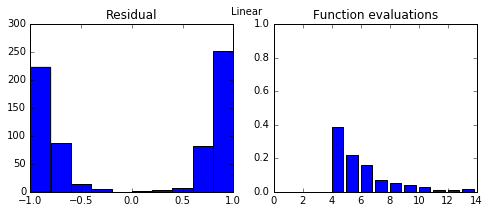

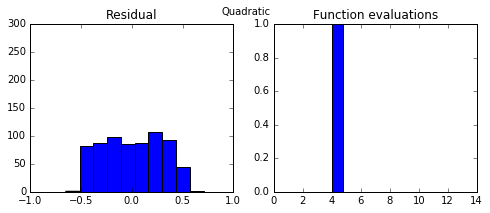

In [38]:
from collections import Counter

for result, name in ((linear_result, 'Linear'), (quadratic_result, 'Quadratic')):
    plt.figure(figsize=(8, 3))
    plt.subplot(1,2,1)
    plt.hist([residual for residual, _ in result])
    plt.title('Residual')
    plt.xlim(-1, 1)
    plt.ylim(0, 300)
    plt.subplot(1,2,2)
    iter_counter = Counter([neval for _, neval in result])
    iterations = sorted(iter_counter.keys())
    iterations_freq = np.array([iter_counter[k] for k in iterations], dtype='float') / len(linear_result)
    plt.bar(iterations, iterations_freq)
    plt.xlim(0, 14)
    plt.ylim(0, 1.0)
    plt.title('Function evaluations')
    plt.suptitle(name)

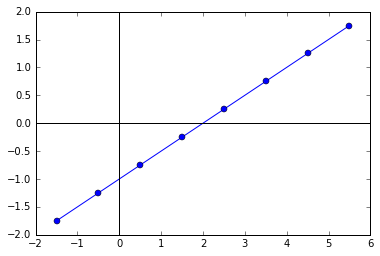

In [46]:
x = np.arange(8) - 1.5
y = 0.5 * x - 1
plt.plot(x, y, '-o')
plt.axvline(0, color='k')
plt.axhline(0, color='k')

In [174]:
class ProjectionError(Exception):
    def __init__(self, roots, xdata, ydata):
        self.roots = roots
        self.xdata = xdata
        self.ydata = ydata
        super(ProjectionError, self).__init__()
        
def project_rs(X, t0, trajectory, camera_model, threshold=0.5, return_evals=False):
    row_delta = float(camera_model.readout) / camera_model.rows
    
    # Two initial test points
    #a = int(0.2 * camera_model.rows)
    a = 0
    pa = project_at_time(t0 + a * row_delta, X, trajectory, camera_model)
    cost_a = a - float(pa[1])
    if np.abs(cost_a) < threshold:
        return (pa, 1) if return_evals else pa
    
    #b = int(0.8 * camera_model.rows)
    b = camera_model.rows - 1
    pb = project_at_time(t0 + b * row_delta, X, trajectory, camera_model)
    cost_b = b - float(pb[1])
    if np.abs(cost_b) < threshold:
        return (pb, 2) if return_evals else pb

    # Use linear model to find new estimate
    c = a - cost_a * (b - a) / (cost_b - cost_a)
    pc = project_at_time(t0 + c * row_delta, X, trajectory, camera_model)
    cost_c = c - float(pc[1])
    if np.abs(cost_c) < threshold:
        return (pc, 3) if return_evals else pc

    # Use quadratic
    q = np.polyfit([a, b, c], [cost_a, cost_b, cost_c], 2)
    try:
        q_roots = np.roots(q)
    except np.linalg.LinAlgError:
        raise ProjectionError(None, [a, b, c], [cost_a, cost_b, cost_c])
    
    # Pick first root within image boundary
    #for row in q_roots:
    #    if 0 <= root < camera_model.rows - 1:
    #        return project_at_time(t0 + row * row_delta, X, trajectory, camera_model)
    
    d = valid_root(q_roots, camera_model)
    if d is None:
        raise ProjectionError(q_roots, [a, b, c], [cost_a, cost_b, cost_c])
    else:
        pd = project_at_time(t0 + d * row_delta, X, trajectory, camera_model)
        cost_d = d - float(pd[1])
        if np.abs(cost_d) > threshold:
            raise ProjectionError(q_roots, [a, b, c], [cost_a, cost_b, cost_c])
        else:
            return (pd, 4) if return_evals else pd

(array([ 68.,  63.,  58.,  63.,  66.,  67.,  71.,  80.,  51.,  67.]),
 array([-0.16894629, -0.13538294, -0.10181958, -0.06825622, -0.03469287,
        -0.00112951,  0.03243385,  0.06599721,  0.09956056,  0.13312392,
         0.16668728]),
 <a list of 10 Patch objects>)

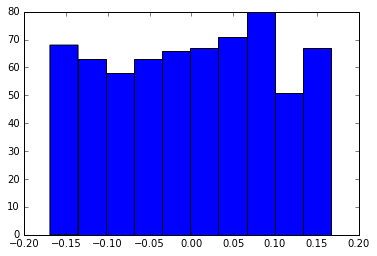

In [145]:
row_all = np.arange(3 * pinhole_camera.rows) / 3.
errors_our = []
pbar = IntProgress(min=0, max=len(problematic) - 1)
display(pbar)
for residual, X, t0 in problematic:
    cost_func = np.vectorize(functools.partial(cost_function_base, t0, X, ds.trajectory, pinhole_camera, method='linear'))
    full_cost = cost_func(row_all)
    row_min = row_all[np.argmin(np.abs(full_cost))]
    try:
        p_our = project_rs(X, t0, ds.trajectory, pinhole_camera)
    except ValueError:
        print 'Failed to project'
    err_our = float(p_our[1]) - row_min
    errors_our.append(err_our)
    pbar.value += 1
plt.hist(errors_our)    

In [146]:
pbar = IntProgress(min=0, max=len(problematic) - 1)
display(pbar)
failed = []
for _, X, t0 in problematic:
    try:
        p = project_rs(X, t0, ds.trajectory, pinhole_camera)
    except ValueError:
        failed.append((X, t0))
    pbar.value += 1
print len(failed), 'failed'

0 failed


roots [  1.06633401e+05  -4.47785392e-02]
x [216, 864, -1.8132904112604535]
y [214.15234879698454, 851.2609557071892, -1.7566087633623457]


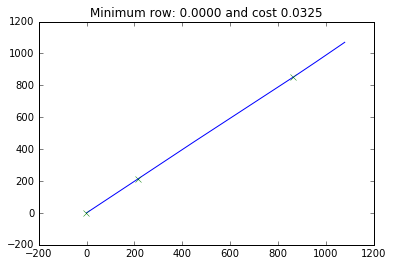

In [141]:
for X, t0 in failed:
    cost_func = np.vectorize(functools.partial(cost_function_base, t0, X, ds.trajectory, pinhole_camera, method='linear'))
    full_cost = cost_func(row_all)
    plt.figure()
    plt.plot(row_all, full_cost)
    min_idx = np.argmin(np.abs(full_cost))
    min_row = row_all[min_idx]
    min_cost = full_cost[min_idx]
    try:
        project_rs(X, t0, ds.trajectory, pinhole_camera)
    except ProjectionError as e:
        plt.plot(e.xdata, e.ydata, 'x')
        print 'roots', e.roots
        print 'x', e.xdata
        print 'y', e.ydata
    plt.title('Minimum row: {:.4f} and cost {:.4f}'.format(min_row, min_cost))

In [112]:
%timeit project_rs(problematic[0][1], problematic[0][2], ds.trajectory, pinhole_camera)

100 loops, best of 3: 1.95 ms per loop


In [98]:
def project_minimize(X, t0, trajectory, camera_model):
    delta_row = float(camera_model.readout) / camera_model.rows
    res_dict = {}
    def cost_func(row):
        t = t0 + row * delta_row
        p = project_at_time(t, X, trajectory, camera_model)
        return (float(p[1]) - row)**2

    res = scipy.optimize.minimize_scalar(cost_func, bounds=(0, camera_model.rows - 1), xatol=0.5)
    return p

print project_minimize(problematic[0][1], problematic[0][2], ds.trajectory, pinhole_camera)
print project_rs(problematic[0][1], problematic[0][2], ds.trajectory, pinhole_camera)


[[ 1426.16543977]
 [  502.97689143]]
[[ 1426.16553817]
 [  502.97696513]]


In [113]:
%timeit project_minimize(problematic[0][1], problematic[0][2], ds.trajectory, pinhole_camera)

100 loops, best of 3: 3.58 ms per loop


742846 projections in 1474.0 seconds (1.984ms/projection)
43576 of those failed: 5.9%
Func eval statistics:
1:    131
2:     11
3: 220898
4: 478230


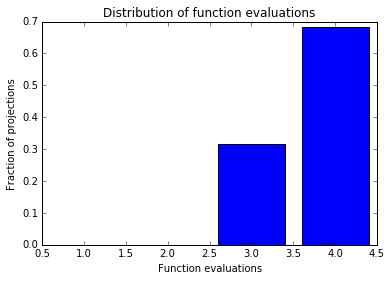

In [187]:
pbar = IntProgress(min=0, max=len(frame_times)-1)
display(pbar)
bench_start = time.time()
num_projections = 0
eval_counter = Counter()
num_failed = 0
problematic_frames = [] # [(t0, [list of landmarks]), ...]
for t0 in frame_times:
    landmarks = ds.visible_landmarks(t0 + 0.5 * pinhole_camera.readout)
#    random.shuffle(landmarks)
    problem_lm = []
    for lm in landmarks:
        try:
            p, neval = project_rs(lm.position.reshape(3,1), t0, ds.trajectory, pinhole_camera, return_evals=True)
            eval_counter[neval] += 1
        except ProjectionError:
            #print 'Failed at time', t0
            num_failed += 1
            problem_lm.append(lm)
        num_projections += 1
    pbar.value += 1
    if problem_lm:
        problematic_frames.append((t0, problem_lm))
duration = time.time() - bench_start
print '{:d} projections in {:.1f} seconds ({:.3f}ms/projection)'.format(num_projections, duration, 1000. * duration/num_projections)
print '{:d} of those failed: {:.1f}%'.format(num_failed, 100. * num_failed / num_projections)
print 'Func eval statistics:'
for neval, count in eval_counter.items():
    print '{:d}: {:>6d}'.format(neval, count)
plt.bar(eval_counter.keys(), np.array(eval_counter.values(), dtype='float') / sum(eval_counter.values()), align='center')
plt.xlabel('Function evaluations')
plt.ylabel('Fraction of projections')
plt.title('Distribution of function evaluations')

### Check problematic cases

     high cost:   703 (0.0%)
  not in image: 42873 (1.0%)


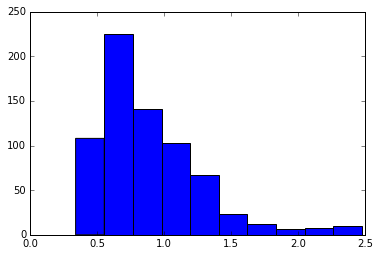

In [224]:
no_roots = []
high_cost = []
pbar = IntProgress(min=0, max=len(problematic_frames)-1)
display(pbar)
failure_reason_counter = Counter()
for frame_time, bad_landmarks in problematic_frames:
    random.shuffle(bad_landmarks)
    for lm in bad_landmarks:
        X = lm.position.reshape(3,1)
        cost_func = np.vectorize(functools.partial(cost_function_base, frame_time, X, ds.trajectory, pinhole_camera, method='linear'))
        cost_all = cost_func(row_all)
        min_row = row_all[np.argmin(np.abs(cost_all))]
        min_cost = np.min(np.abs(cost_all))
        if min_cost > 1:
            failure_reason_counter['not in image'] += 1
            continue
        #plt.figure()
        #plt.plot(row_all, cost_all)
        #plt.axvline(min_row, linestyle='--', color='k')
        #print 'Minimum cost {:.1f} at {:.1f}'.format(np.min(np.abs(cost_all)), min_row)
        try:
            p = project_rs(X, frame_time, ds.trajectory, pinhole_camera)
        except ProjectionError as e:
            if e.roots is not None:
                min_root_error = np.min(np.abs(e.roots - min_row))
                #if min_root_error > 500:
                #    plt.figure()
                #    plt.plot(row_all, cost_all)
                #    plt.axvline(min_row, linestyle='--', color='k')
                high_cost.append(min_root_error)
                failure_reason_counter['high cost'] += 1
            else:
                failure_reason_counter['no roots'] += 1
                no_roots.append((frame_time, lm))
    pbar.value += 1
plt.hist(high_cost)
for reason, count in failure_reason_counter.items():
    print '{:>14s}: {:>5d} ({:.1f}%)'.format(reason, count, float(count) / sum(failure_reason_counter.values()))

In [221]:
sum(failure_reason_counter.values())

828

In [214]:
0.260 * 420 * 3 / (60.)

5.46

* Itererande metod. Släng punkter längre bort.
* Går att göra med antingen linjär eller kvadratisk metod
* Kolla upp Brent

#### Ground truth generation
1. Grid over all rows (1/3 step)
1. Find minimum
1. Start new minimization in that point
1. Check if final point is within image (row **and column**)

### Action plan
1. Generate ground truth
1. Run our against ground truth
  * General method (max=10 iterations?)
  * Check error distribution
  * Check iteration count distribution
1. Implement and compare Newton-Raphson
1. Implement and compare Spline-fusion solver